##NeuroData Design Week 2: Understanding The Decision Tree Strucuture
Taken from the following tutorials/blog post: 

https://towardsdatascience.com/understanding-decision-trees-once-and-for-all-2d891b1be579

https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html



## Import Libraries

In [14]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import seaborn as sns
from sklearn.metrics import accuracy_score

# Load Data 

This dataset is made up of 4 features : the petal length, the petal width, the sepal length and the sepal width. The target variable to predict is the iris species. There are three of them : iris setosa, iris versicolor and iris virginica.

In [2]:
iris = load_iris()
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris_df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


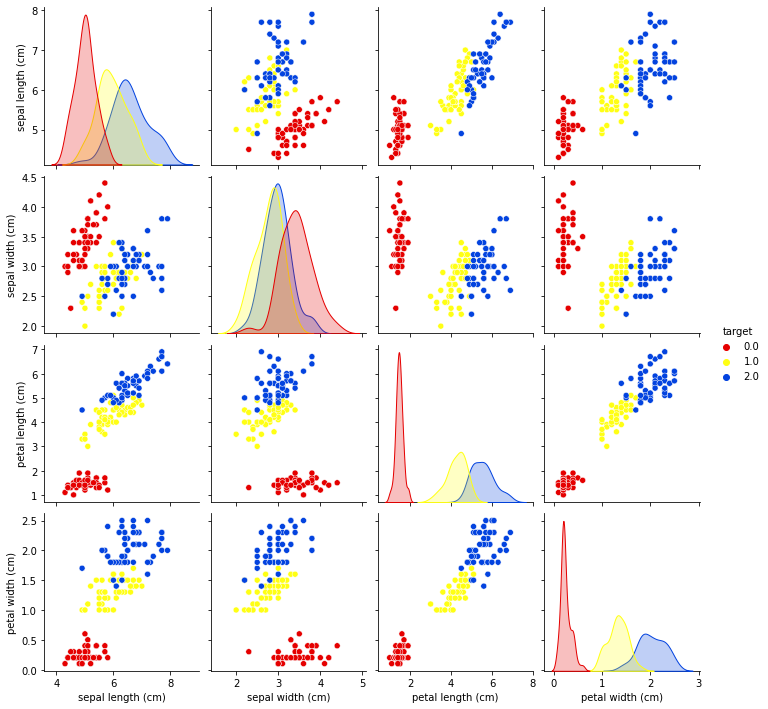

In [19]:
colors = ['red', 'yellow', 'blue']
sns.pairplot(iris_df, hue='target', palette=sns.xkcd_palette(colors))

# Train Tree Classifier

In [3]:

X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
clf.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=3,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

The decision classifier has an attribute called tree_ which allows access to low level attributes such as node_count, the total number of nodes, and max_depth, the maximal depth of the tree. It also stores the entire binary tree structure, represented as a number of parallel arrays. The i-th element of each array holds information about the node i. Node 0 is the tree’s root. Some of the arrays only apply to either leaves or split nodes. In this case the values of the nodes of the other type is arbitrary. For example, the arrays feature and threshold only apply to split nodes. The values for leaf nodes in these arrays are therefore arbitrary.

Among these arrays, we have:

- children_left[i]: id of the left child of node i or -1 if leaf node
- children_right[i]: id of the right child of node i or -1 if leaf node
- feature[i]: feature used for splitting node i
- threshold[i]: threshold value at node i
- n_node_samples[i]: the number of of training samples reaching node i
- impurity[i]: the impurity at node i

Using the arrays, we can traverse the tree structure to compute various properties. Below, we will compute the depth of each node and whether or not it is a leaf.

In [5]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has {n} nodes and has "
      "the following tree structure:\n".format(n=n_nodes))
for i in range(n_nodes):
    if is_leaves[i]:
        print("{space}node={node} is a leaf node.".format(
            space=node_depth[i] * "\t", node=i))
    else:
        print("{space}node={node} is a split node: "
              "go to node {left} if X[:, {feature}] <= {threshold} "
              "else to node {right}.".format(
                  space=node_depth[i] * "\t",
                  node=i,
                  left=children_left[i],
                  feature=feature[i],
                  threshold=threshold[i],
                  right=children_right[i]))


The binary tree structure has 5 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 3] <= 0.800000011920929 else to node 2.
	node=1 is a leaf node.
	node=2 is a split node: go to node 3 if X[:, 2] <= 4.950000047683716 else to node 4.
		node=3 is a leaf node.
		node=4 is a leaf node.


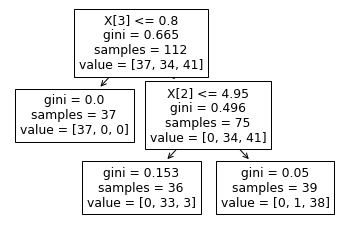

In [6]:
tree.plot_tree(clf)
plt.show()

# Decision Path:
## retrieve the nodes the samples of interest traverse through

In [7]:
node_indicator = clf.decision_path(X_test)
leaf_id = clf.apply(X_test)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample {id}:\n'.format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision node {node} : (X_test[{sample}, {feature}] = {value}) "
          "{inequality} {threshold})".format(
              node=node_id,
              sample=sample_id,
              feature=feature[node_id],
              value=X_test[sample_id, feature[node_id]],
              inequality=threshold_sign,
              threshold=threshold[node_id]))

Rules used to predict sample 0:

decision node 0 : (X_test[0, 3] = 2.4) > 0.800000011920929)
decision node 2 : (X_test[0, 2] = 5.1) > 4.950000047683716)


For a group of samples: 

In [8]:
sample_ids = [0, 1]
# boolean array indicating the nodes both samples go through
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))
# obtain node ids using position in array
common_node_id = np.arange(n_nodes)[common_nodes]

print("\nThe following samples {samples} share the node(s) {nodes} in the "
      "tree.".format(samples=sample_ids, nodes=common_node_id))
print("This is {prop}% of all nodes.".format(
    prop=100 * len(common_node_id) / n_nodes))


The following samples [0, 1] share the node(s) [0 2] in the tree.
This is 40.0% of all nodes.


# Further exploration...

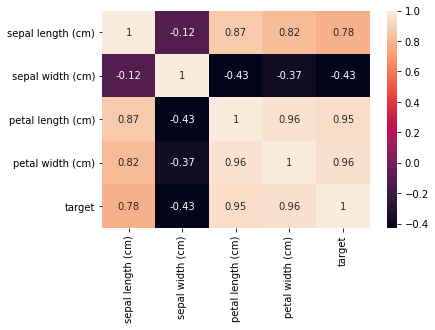

In [10]:
corr = iris_df.corr()
sns.heatmap(corr, annot=True)
# get names of targets
iris_df['target'] = iris_df['target'].map({0: iris['target_names'][0],
                                          1: iris['target_names'][1],
                                          2: iris['target_names'][2]})

 select petal width and sepal width because there not too correlated (-0.37), as we can see on the heatmap, and in a 2D plane they give a good separation of the target variable as we can see on the pairplot.

In [11]:
# drop the duplicates so that we can every dot on the graph
iris_df = iris_df.drop_duplicates(subset=['petal width (cm)', 'sepal width (cm)'], keep='first')
features = ['petal width (cm)', 'sepal width (cm)']
X = iris_df[features]
y = iris_df['target']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("accuracy score: " + str(accuracy_score(y_test, y_pred)))


accuracy score: 0.9333333333333333


# more advanced tree graph

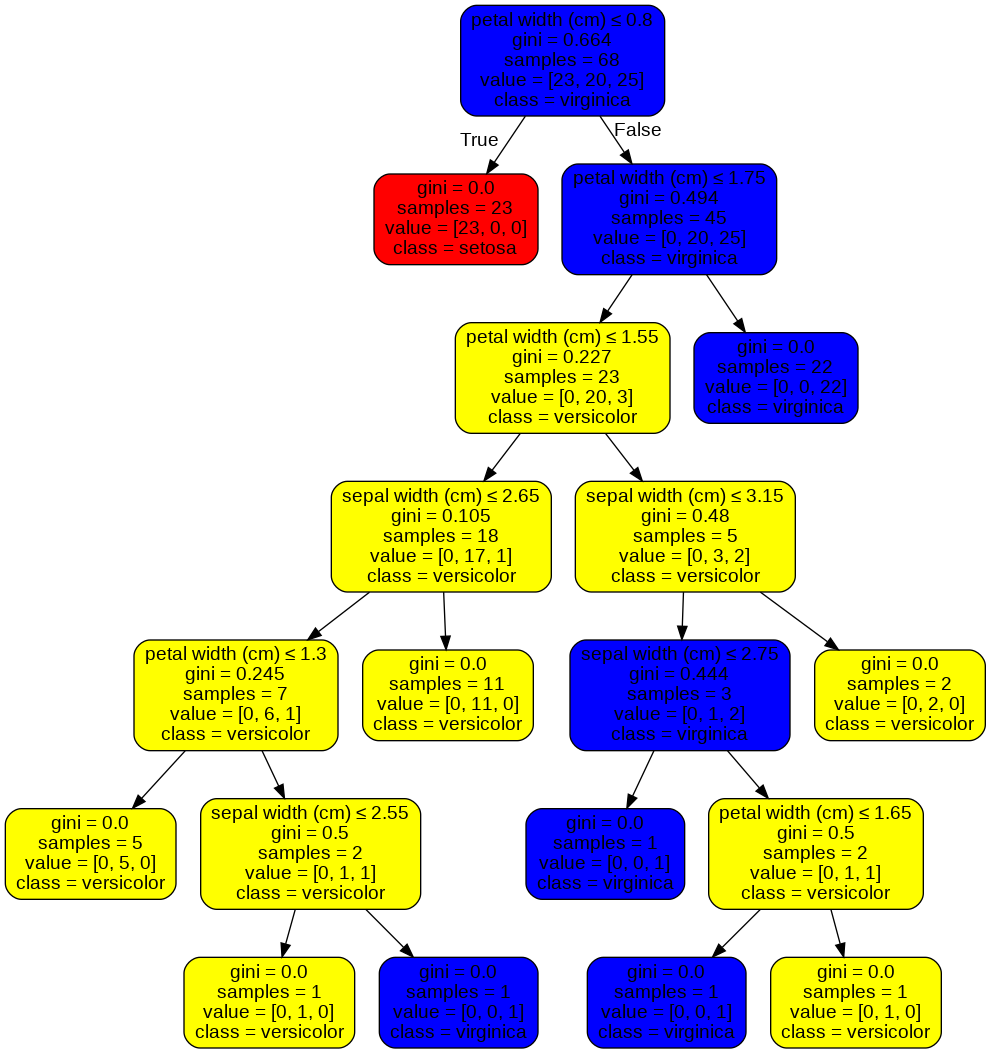

In [21]:
import pydotplus
from IPython.display import Image, display
dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=features,  
                                class_names=iris.target_names,  
                                filled=True, rounded=True,  
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('red', 'yellow', 'blue')
nodes = graph.get_node_list()

for node in nodes:
  if node.get_label():
    values = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')]
    color = '#{:02x}{:02x}{:02x}'.format(values[0], values[1], values[2])
    node.set_fillcolor(colors[np.argmax(values)])

graph.write_png('colored_tree.png')



def viewPydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

viewPydot(graph)



In [22]:
def get_lines(depth, lim, node_n=0):
  '''
  Fetches the lines corresponding to the decision boundaries for the tree
  at given depth
  depth : depth maximum where to fetch the lines
  lim : the frame defined to plot the graph
  node_n : node to fetch the lines
  '''
  seg = np.zeros((2,2))

  if depth==-1:
    return seg
  else:
    f = model.tree_.feature[node_n]

    lc_node_n = model.tree_.children_left[node_n]
    rc_node_n = model.tree_.children_right[node_n]

    if f<0:
      return seg
    else:
      thres = model.tree_.threshold[node_n]

      seg[f,:] = thres
      seg[1-f,:] = lim[1-f,:]

      if (lc_node_n==-1) and (rc_node_n)==-1:
        return seg
      else:
        l_lim = lim.copy()
        r_lim = lim.copy()

        l_lim[f, 1] = float(thres)
        r_lim[f, 0] = float(thres)

        seg = np.concatenate((seg, get_lines(depth-1, l_lim, lc_node_n)), axis=0) if not np.array_equal(get_lines(depth-1, l_lim, lc_node_n), np.zeros((2,2))) else seg
        seg = np.concatenate((seg, get_lines(depth-1, r_lim, rc_node_n)), axis=0) if not np.array_equal(get_lines(depth-1, r_lim, rc_node_n), np.zeros((2,2))) else seg
        return seg
      
    
def get_decision_boundaries(depth, lim):
  '''
  Wrapper and formatter of the get_lines function
  '''
  segs = get_lines(depth, lim)
  segments = []
  for i in range(0,len(segs),2):
    segments.append(segs[i:i+2,:])
  return segments



def get_pred(feat, depth, node_n=0):
  '''
  Get the predictions of the decision tree at a given depth.
  feat : coordinates (features) of the point
  depth : depth at which the prediction is computed
  node_n : node_n deciding the prediction
  '''
  f = model.tree_.feature[node_n]
  # leaf
  if f<0:
    pred = np.argmax(model.tree_.value[node_n])
    return pred
  elif depth==0:
    pred = np.argmax(model.tree_.value[node_n])
    return pred
  else:
    if (feat[f]<=model.tree_.threshold[node_n]):
      lc_node_n = model.tree_.children_left[node_n]
      return get_pred(feat, depth-1, lc_node_n)
    else:
      rc_node_n = model.tree_.children_right[node_n]
      return get_pred(feat, depth-1, rc_node_n)


def plot_decision(depth, boundaries=True):
  
  plt.style.use('seaborn-white')

  labels = iris['target_names']
  plot_colors = 'ryb'
  plot_step = 0.02

  # We define a grid of points from which we will make predictions
  x_min, x_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
  y_min, y_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                       np.arange(y_min, y_max, plot_step))

  lim = np.array([[x_min, x_max-0.02],[y_min,y_max-0.05]])

  # Plot the background color which depicts the decision of the tree
  Z = []
  for feat in np.c_[xx.ravel(), yy.ravel()]:
      Z.append(get_pred(feat,depth))
  Z[0]=1
  Z = np.array(Z).reshape(xx.shape)
  cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, zorder=0)

  if boundaries:
    # Plot the boundaries of the decision tree
    segments = get_decision_boundaries(depth, lim)
    for seg in segments:
      plt.plot(seg[0,:], seg[1,:], 'k-')

  # Plot the training data
  for j, (species, color) in enumerate(zip(labels, plot_colors)):
    idx = y_train.index[y_train==species]
    plt.scatter(X_train.loc[idx][features[0]], X_train.loc[idx][features[1]], c=color, label=labels[j], cmap=plt.cm.RdYlBu, edgecolor='black', s=30, zorder=1)

  legend = plt.legend()
  plt.xlabel(features[0])
  plt.ylabel(features[1])
  plt.title('Decision tree at depth {}'.format(depth))

# Analyzing The Decision Tree

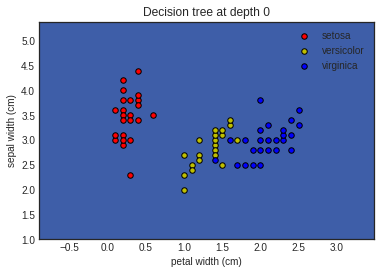

In [25]:
#Root node 
plot_decision(0,False)

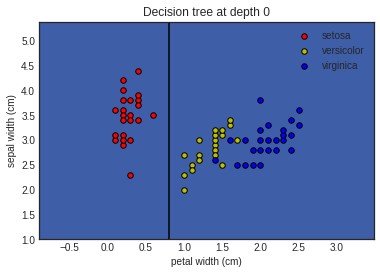

In [26]:
# root node with boundary 
plot_decision(0,True)

This plot is the same as the previous one but with the first decision boundary of the tree : `petal width = 0.8 cm`. 

**How was this decision boundary decided ? **

A decision boundary is decided by testing all the possible decision boundaries splitting the dataset and choosing the one that minimizes the Gini impurity of the two splits. 

**What is Gini impurity ?**

Gini impurity is a metric that measures the probability from a randomly chosen element to be incorrectly classified, i.e. the probability $p_i$ of choosing an element $i$ times the probability of being misclassified  $\sum_{k!=i} p_k = 1 - p_i$. If we sum over all $J$ possible classes we have : 
$\sum_{i=1}^{J}p_i \sum_{k!=i}p_k = \sum_{i=1}^{J}p_i(1-p_i) = \sum_{i=1}^{J} (p_i - p_i^2) =  \sum_{i=1}^{J} p_i - \sum_{i=1}^{J} p_i^2 = 1 - \sum_{i=1}^{J} p_i^2 $

This is the last formula we are going to use to perform the Gini test.

**Let's compute the Gini impurity for the first node **

At the root node all the data points are mixed. Gini impurity is $1 - p_{se}^2 - p_{ve}^2 - p_{vi}^2$ with :
* $p_{se}$  the probability of choosing a setosa;
* $p_{ve}$ the probability of choosing a versicolor;
* $ p_{vi}$ the probability of choosing a virginica.
This gives us : $1- (\frac{23}{68})^2 - (\frac{20}{68})^2 - (\frac{25}{68})^2 = 0.664$

We can verify this number by checking the tree we displayed earlier. For the first node we have a Gini impurity of 0.664.

**Let's get back to the first decision boundary**

The question to be asked is : how to split the iris species so that we create more homogeneous groups ? <br/>
Intuitively what we can observe that we can create a homogeneous group containing only setosa species just by splitting the dataset along the `petal width` axis.

**But the algorithm has no intuition. So how does it find the best split ? ** <br/>
It will try all the possible boundaries along all the features, i.e. all the axes `petal width` and` sepal width`. For each split the algorithm will compute the Gini impurity of the two groups. Finally it will choose the decision boundary that give the lowest Gini impurity for the two groups (either summing the Gini impurity for each group or doing a mean).

**Let's get back to the first node and the first split ** <br/>
In the case of the root node, the algorithm has found that among all the possible splits the split with `petal width <= 0.8`. <br/>
The Gini impurity for the left leaf is :
$1 - p_{se}^2 - p_{ve}^2 - p_{vi}^2 = 1 - p_{se}^2 = 1 - (\frac{23}{23})^2=0$. We verify this result with the tree graph. This result is not surprising because in the left leaf which matches the left part of the graph we only have setosa iris, so the group is very homogenous and Gini impurity is a measure of homogeneity. <br/>
The Gini impurity for the right leaf is : <br/>
$1 - p_{se}^2 - p_{ve}^2 - p_{vi}^2 = 1 - p_{ve}^2 - p_{vi}^2 = 1 - (\frac{20}{45})^2 - (\frac{25}{45})^2 = 0.494$. We find the same result as the one shown in the tree graph. Moreover this Gini impurity is close to 0.5 because there are almost as much virginica irises as versicolor.

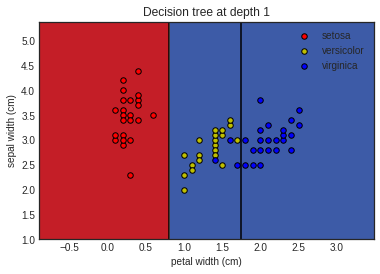

In [27]:
plot_decision(1,True)

For this node the algorithm chose to split the tree at petal width = 1.55 creating two heterogenous groups. Intuitively we would have split at petal width = 1.3 or sepal width = 3.1 to create a group with only versicolor irises. Indeed this would have created a node with a Gini impurity at 0. But in fact the other node created is more heterogenous so much so that the Gini impurity of this node is bigger than the Gini impurity of the sum of the two nodes created with the other split.

**Let's verify this :**

**Gini impurity with the split at `petal width = 1.55`**
* Left node : $1 - p_{ve}^2 - p_{vi}^2 = 1 - (\frac{17}{18})^2 -  (\frac{1}{18})^2 = 0.105 $. We verify this result on the tree.
* Right node : $1 - p_{ve}^2 - p_{vi}^2 = 1 - (\frac{3}{5})^2 -  (\frac{2}{5})^2 = 0.48 $. Again we verify this result on the tree. <br/>
The Gini impurity for this split is : $\frac{18}{18+5} * 0.105 + \frac{5}{23} * 0.48 = 0.187$. The Gini index for this split is ponderated by the number of points for each group.

**Gini impurity with the split at `petal widht = 1.3`**
* Left node : $1 - p_{ve}^2 = 1 - \frac{8}{8}^2 = 0$
* Right node : $1 - p_{ve}^2 - p_{vi}^2 = 1 - (\frac{12}{15})^2 -  (\frac{3}{15})^2 = 0.32$ <br/>
The Gini impurity for this split is : $\frac{8}{23} * 0 + \frac{15}{23} * 0.32 = 0.209$

The algorithm is right and our intuition was wrong. Indeed the first split produces the lowest Gini impurity so this split is preferable.
The algorithm tries each possible split for each feature.

6


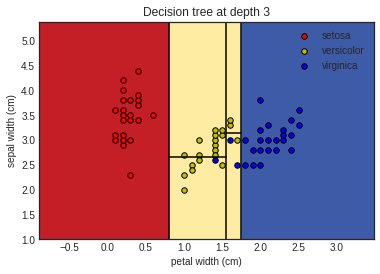

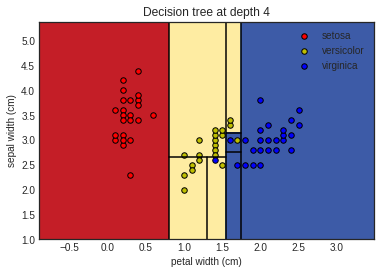

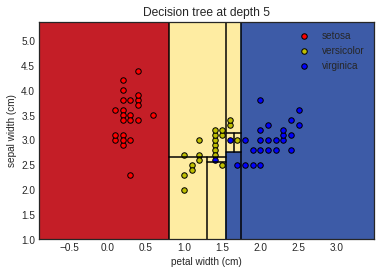

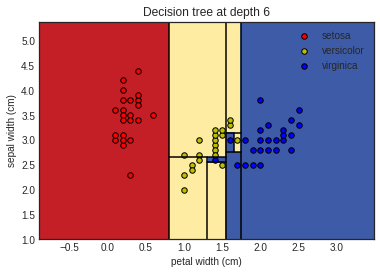

In [30]:
tree_depth = model.tree_.max_depth
print(tree_depth)
for i in range(3, tree_depth+1):
  plot_decision(i)
  plt.show()